In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [249]:
surv['Survived'].value_counts() 

GE5    225
L5      81
Name: Survived, dtype: int64

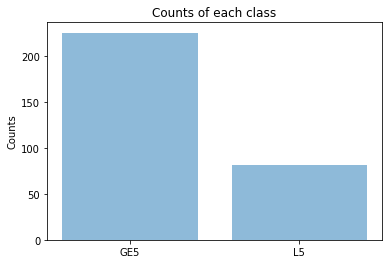

In [250]:
objects = ('GE5', 'L5')
y_pos = np.arange(len(objects))
performance = [Counter(surv.Survived)['GE5'], Counter(surv.Survived)['L5']]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Counts')
plt.title('Counts of each class')

plt.show()

You can clearly see that this is a very unbalanced dataset. There are nearly 3 times more cases of GE5 class than there is of L5.

In [251]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape

((306, 3), (306,))

In [252]:
print("Minority class : %0.2f" % (Counter(y)['L5']/len(y)))

Minority class : 0.26


# Models
In this analysis I will us 4 different classifiers
- k-NN
- Decision Trees 
- Logistic Regression
- Gradient Boosting

In [253]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

model_d = {}

model_d['dtree'] = DecisionTreeClassifier(criterion='entropy')
model_d['kNN'] = KNeighborsClassifier(n_neighbors=3)  
model_d['gradientBoost'] = GradientBoostingClassifier()
model_d['logistic'] = LogisticRegression(max_iter=10000, solver = 'sag', random_state=0)


# Hold out testing
I will first compare each model using hold out testing.

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
bias_d = {}
acc_bl = {}

#print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))

for m in model_d:
    y_pred = model_d[m].fit(X_train, y_train).predict(X_test)

    pred_neg = Counter(y_pred)['L5']
    test_neg = Counter(y_test)['L5']
    bias_d[m] = pred_neg/len(y_pred)
    
    print("{:22}".format(type(model_d[m]).__name__))
    print(X_train.shape,X_test.shape)
    print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
    acc_bl[m] = accuracy_score(y_pred, y_test)
    print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
    print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
    print('*********************')

DecisionTreeClassifier
(229, 3) (77, 3)
Accuracy:  0.62
Minority class in test set : 0.40
Predicted minority class : 0.23
*********************
KNeighborsClassifier  
(229, 3) (77, 3)
Accuracy:  0.64
Minority class in test set : 0.40
Predicted minority class : 0.17
*********************
GradientBoostingClassifier
(229, 3) (77, 3)
Accuracy:  0.57
Minority class in test set : 0.40
Predicted minority class : 0.16
*********************
LogisticRegression    
(229, 3) (77, 3)
Accuracy:  0.61
Minority class in test set : 0.40
Predicted minority class : 0.04
*********************


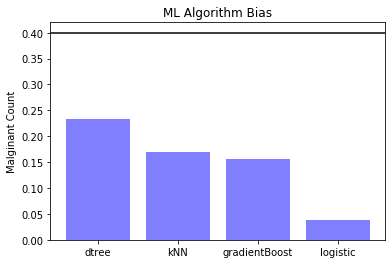

In [255]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive = list(bias_d.values())

y_pos = np.arange(len(objects))

plt.bar(y_pos, positive, align='center', color=['blue', 'blue','blue','blue'],alpha=0.5)
plt.axhline(y= round(test_neg/len(y_test),1), color='black', linestyle='-')
plt.xticks(y_pos, objects)
plt.ylabel('Malginant Count')
plt.title('ML Algorithm Bias')
 
plt.show()

### Hold- Out Testing Discussion
The test set contained 40% L5 and 60% GE5.
- Assessment of bias is independent of accuracy, i.e. proportion of examples classified as the minority class compared with the actual proportion in the test set.
- Every model appears to be biased towards the majority class as each model predicts less than 40% L5 class.
- Logistic regression showed the most bias, only predicting 4% L5 class.
- Gradient boosting predicted only 16% L5 class, which again is significantly lower than the target of 40%.
- K-NN wasnt much better as it predicted 17% L5 class.
- Decision tree showed the least biased predicting 25% L5 class. Although this was the least biased it still is very biased towards the majority class as 25% is significantly lover than 40%.

# Cross validation
I will now compare each model using cross validation. Cross-validation is a statistical method used to estimate the skill of machine learning models. I will use 3-fold, 5-fold and 10-fold cross validation.

In [280]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

v = 0 #  use 1 or 0

In [281]:
bias_cvx3 = {}
folds = 3
for m in model_d:
    cv_results = cross_validate(model_d[m], X, y, cv= folds,scoring=scoring, return_train_score=False,verbose = v, n_jobs = -1)
    n_tot = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tn'].sum() + cv_results['test_tp'].sum())/len(y)
    bias_cvx3[m] = n_tot
  
    print("{} x CV {:22} N: {:d} Pred N: {:d} Acc: {:.2f}".format(folds, type(model_d[m]).__name__, 81 , n_tot,acc)) 

3 x CV DecisionTreeClassifier N: 81 Pred N: 66 Acc: 0.65
3 x CV KNeighborsClassifier   N: 81 Pred N: 68 Acc: 0.68
3 x CV GradientBoostingClassifier N: 81 Pred N: 53 Acc: 0.71
3 x CV LogisticRegression     N: 81 Pred N: 27 Acc: 0.75


In [282]:
bias_cvx5 = {}
folds = 5
for m in model_d:
    cv_results = cross_validate(model_d[m], X, y, cv= folds,scoring=scoring, return_train_score=False,verbose = v, n_jobs = -1)
    n_tot = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tn'].sum() + cv_results['test_tp'].sum())/len(y)
    bias_cvx5[m] = n_tot
  
    print("{} x CV {:22} N: {:d} Pred N: {:d} Acc: {:.2f}".format(folds, type(model_d[m]).__name__, 81 , n_tot,acc)) 


5 x CV DecisionTreeClassifier N: 81 Pred N: 97 Acc: 0.62
5 x CV KNeighborsClassifier   N: 81 Pred N: 76 Acc: 0.66
5 x CV GradientBoostingClassifier N: 81 Pred N: 72 Acc: 0.64
5 x CV LogisticRegression     N: 81 Pred N: 23 Acc: 0.75


In [283]:
bias_cvx10 = {}
folds = 10
for m in model_d:
    cv_results = cross_validate(model_d[m], X, y, cv= folds,scoring=scoring, return_train_score=False,verbose = v, n_jobs = -1)
    n_tot = cv_results['test_tp'].sum() + cv_results['test_fp'].sum()
    acc = (cv_results['test_tn'].sum() + cv_results['test_tp'].sum())/len(y)
    bias_cvx10[m] = n_tot
  
    print("{} x CV {:22} N: {:d} Pred N: {:d} Acc: {:.2f}".format(folds, type(model_d[m]).__name__, 81 , n_tot,acc)) 


10 x CV DecisionTreeClassifier N: 81 Pred N: 98 Acc: 0.61
10 x CV KNeighborsClassifier   N: 81 Pred N: 69 Acc: 0.67
10 x CV GradientBoostingClassifier N: 81 Pred N: 76 Acc: 0.62
10 x CV LogisticRegression     N: 81 Pred N: 24 Acc: 0.75


In [284]:
for key in bias_cvx3:
    bias_cvx3[key]= bias_cvx3[key]/len(y)

for key in bias_cvx5:
    bias_cvx5[key]= bias_cvx5[key]/len(y)
    
for key in bias_cvx10:
    bias_cvx10[key]= bias_cvx10[key]/len(y)

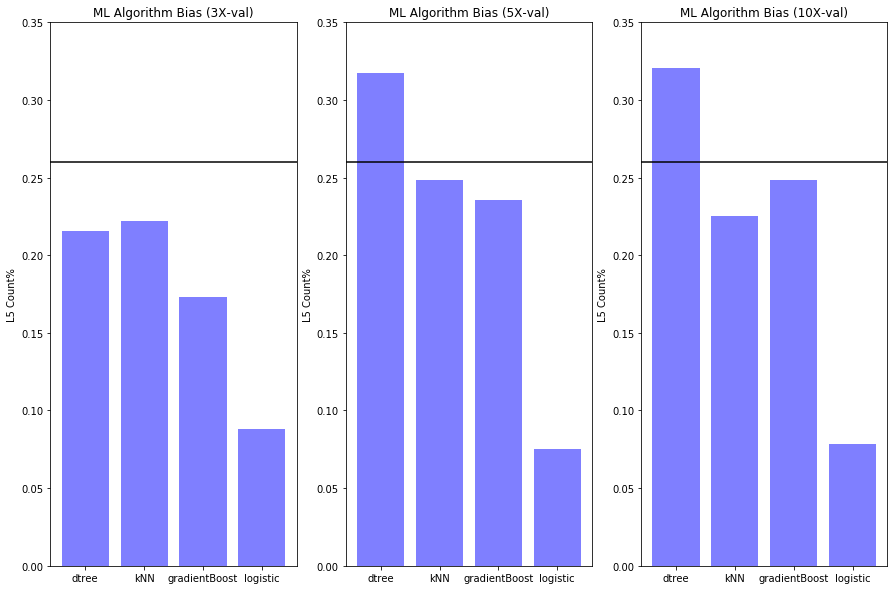

In [285]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

objects = list(bias_cvx3.keys())
positivex3 = list(bias_cvx3.values())
positivex5 = list(bias_cvx5.values())
positivex10 = list(bias_cvx10.values())

fig, ax = plt.subplots(figsize=(15,10))
y_pos = np.arange(len(objects))
plt.subplot(1, 3, 1)
plt.bar(y_pos, positivex3, align='center', color=['blue', 'blue','blue','blue','blue'],alpha=0.5)
plt.axhline(y= round(Counter(y)['L5']/len(y),2), color='black', linestyle='-')
plt.yticks([0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35])
plt.xticks(y_pos,objects)
plt.ylabel('L5 Count%')
plt.title('ML Algorithm Bias (3X-val)')

plt.subplot(1, 3, 2)
y_pos = np.arange(len(objects))

plt.bar(y_pos, positivex5, align='center', color=['blue', 'blue','blue','blue','blue'],alpha=0.5)
plt.axhline(y= round(Counter(y)['L5']/len(y),2), color='black', linestyle='-')
plt.yticks([0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35])
plt.xticks(y_pos,objects)
plt.ylabel('L5 Count%')
plt.title('ML Algorithm Bias (5X-val)')

plt.subplot(1, 3, 3)
y_pos = np.arange(len(objects))

plt.bar(y_pos, positivex10, align='center', color=['blue', 'blue','blue','blue','blue'],alpha=0.5)
plt.axhline(y= round(Counter(y)['L5']/len(y),2), color='black', linestyle='-')
plt.yticks([0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35])
plt.xticks(y_pos,objects)
plt.ylabel('L5 Count%')
plt.title('ML Algorithm Bias (10X-val)')
 
plt.show()

### X-Val Testing Discussion
- 10 and 5 fold cross validation seemed to produce the best results.
- This assessment is more robust than Hold-Out Testing because all data is consisered. 
  - We have 81 minority class examples compared with 31 (40% of the test set) in hold-out.
- Gradient boosting and kNN are not really showing any bias in both 10 and 5 fold.
- Logisitic regression is still showing significant bias.

# Question 2
I will now look a 3 strategies to rectify this bias.
The 3 strategies are:
- Downsampling
- Upsampling
- Up and down-sampling

In [27]:
# check version number
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [28]:
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [29]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape

((306, 3), (306,))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Downsampling
The imbalanced-learn library supports random undersampling via the RandomUnderSampler class.

In [31]:
rus = RandomUnderSampler()
X_train_res1, y_train_res1 = rus.fit_sample(X_train, y_train)

In [32]:
print("Original Training")
print("Majority class:",Counter(y_train)['GE5'])
print("Minority class:", Counter(y_train)['L5'])
print("Upsampled Training")
print("Majority class:",Counter(y_train_res1)['GE5'])
print("Minority class:",Counter(y_train_res1)['L5'])

Original Training
Majority class: 179
Minority class: 50
Upsampled Training
Majority class: 50
Minority class: 50


In [33]:
res1_d = {}
acc_res1 = {}


for m in model_d:
    y_pred = model_d[m].fit(X_train_res1, y_train_res1).predict(X_test)

    pred_neg = Counter(y_pred)['L5']
    test_neg = Counter(y_test)['L5']
    res1_d[m] = pred_neg/len(y_pred)
    
    print("{:22}".format(type(model_d[m]).__name__))
    print(X_train_res1.shape,X_test.shape)
    print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
    acc_res1[m] = accuracy_score(y_pred, y_test)
    print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
    print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))

DecisionTreeClassifier
(100, 3) (77, 3)
Accuracy:  0.58
Minority class in test set : 0.40
Predicted minority class : 0.48
KNeighborsClassifier  
(100, 3) (77, 3)
Accuracy:  0.64
Minority class in test set : 0.40
Predicted minority class : 0.40
GradientBoostingClassifier
(100, 3) (77, 3)
Accuracy:  0.60
Minority class in test set : 0.40
Predicted minority class : 0.42
LogisticRegression    
(100, 3) (77, 3)
Accuracy:  0.65
Minority class in test set : 0.40
Predicted minority class : 0.29


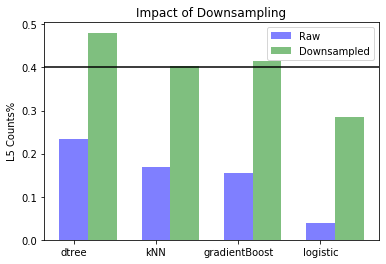

In [34]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

fig, ax = plt.subplots()
width = 0.35

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive =list(bias_d.values())
res = list(res1_d.values())

y_pos = np.arange(len(objects))

p1 = ax.bar(y_pos, positive, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)

p2 = ax.bar(y_pos+width, res, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)

plt.axhline(y= round(test_neg/len(y_test), 1), color='black', linestyle='-')

ax.legend((p1[1], p2[1]), ('Raw', 'Downsampled'))

plt.xticks(y_pos, objects)
plt.ylabel('L5 Counts%')
plt.title('Impact of Downsampling')
 
plt.show()

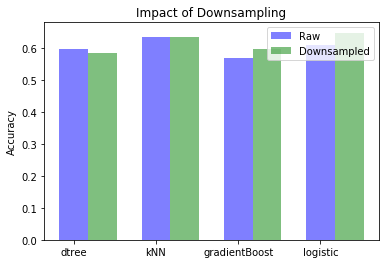

In [35]:
fig, ax = plt.subplots()

objects =  list(acc_bl.keys())
before =   list(acc_bl.values())
after =  list(acc_res1.values())
y_pos = np.arange(len(objects))
p1 = ax.bar(y_pos, before, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width, after, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)
ax.legend((p1[1], p2[1]), ('Raw', 'Downsampled'))
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Impact of Downsampling')
plt.show()

### Downsampling - Discussion

The solution we propose is to downsample the majority class data in training. 
- The assessment is unstable in that different runs produce different results. 
- Downsampling on a dataset this small isnt a good idea and produces very inconsistent results. Upsampling is probably a better idea.
- Although downsampling isnt the best method with such a small dataset, the bias is improved using it. 
### **This is may be a good strategy, however it is not recommended to be used for a small dataset as the results are too inconsistent.**

# Upsampling
We can define a SMOTE instance with default parameters that will balance the minority class and then fit and apply it in one step to create a transformed version of our dataset. SMOTE produces additional synthetic minority class samples by interpolating between real samples.  
We configure SMOTE to bring up the minority class count level with the majority class. 

In [36]:
sm = SMOTE(random_state=12)
X_train_res2, y_train_res2 = sm.fit_sample(X_train, y_train)

In [37]:
print("Original Training")
print("Majority class:",Counter(y_train)['GE5'])
print("Minority class:", Counter(y_train)['L5'])
print("Upsampled Training")
print("Majority class:",Counter(y_train_res2)['GE5'])
print("Minority class:",Counter(y_train_res2)['L5'])

Original Training
Majority class: 179
Minority class: 50
Upsampled Training
Majority class: 179
Minority class: 179


In [38]:
res2_d = {}
acc_res2 = {}


for m in model_d:
    y_pred = model_d[m].fit(X_train_res2, y_train_res2).predict(X_test)

    pred_neg = Counter(y_pred)['L5']
    test_neg = Counter(y_test)['L5']
    res2_d[m] = pred_neg/len(y_pred)
    
    print("{:22}".format(type(model_d[m]).__name__))
    print(X_train_res2.shape,X_test.shape)
    print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
    acc_res2[m] = accuracy_score(y_pred, y_test)
    print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
    print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))

DecisionTreeClassifier
(358, 3) (77, 3)
Accuracy:  0.58
Minority class in test set : 0.40
Predicted minority class : 0.35
KNeighborsClassifier  
(358, 3) (77, 3)
Accuracy:  0.64
Minority class in test set : 0.40
Predicted minority class : 0.32
GradientBoostingClassifier
(358, 3) (77, 3)
Accuracy:  0.62
Minority class in test set : 0.40
Predicted minority class : 0.26
LogisticRegression    
(358, 3) (77, 3)
Accuracy:  0.65
Minority class in test set : 0.40
Predicted minority class : 0.26


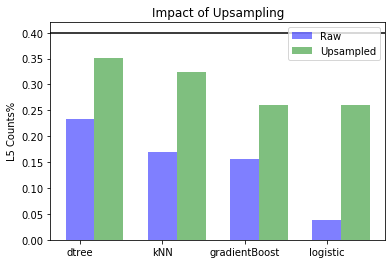

In [39]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

fig, ax = plt.subplots()
width = 0.35

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive = list(bias_d.values())
res = list(res2_d.values())

y_pos = np.arange(len(objects))

p1 = ax.bar(y_pos, positive, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)

p2 = ax.bar(y_pos+width, res, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)

plt.axhline(y= round(test_neg/len(y_test), 1), color='black', linestyle='-')
ax.legend((p1[1], p2[1]), ('Raw', 'Upsampled'))

plt.xticks(y_pos, objects)
plt.ylabel('L5 Counts%')
plt.title('Impact of Upsampling')
 
plt.show()

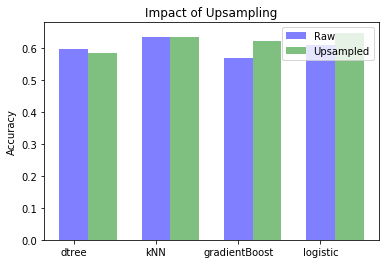

In [40]:
fig, ax = plt.subplots()

objects =  list(acc_bl.keys())
before =   list(acc_bl.values())
after =  list(acc_res2.values())
y_pos = np.arange(len(objects))
p1 = ax.bar(y_pos, before, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width, after, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)
ax.legend((p1[1], p2[1]), ('Raw', 'Upsampled'))
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Impact of Upsampling')
plt.show()

### Upsampling - Discussion

The solution we propose is to upsample the minority class data in training. 
- The solution works pretty well, across multiple runs the bias is reduced. 
- The assessment is unstable in that different runs produce slightly different results. However the results are much more staple than downsampling. 
- There was no impact on the accuracy for kNN.
- The accuracy was slightly reduced for decision tree, while the accuracy increased for both gradient Boosting and logistic regression.
### **This is a good strategy as it reduces the bias while also increasing the accuracy for some models.**

# Upsampling and Downsampling
The [original paper on SMOTE](https://arxiv.org/abs/1106.1813) suggested combining SMOTE with random undersampling of the majority class.

We can update the example to first oversample the minority class to have 60 percent the number of examples of the majority class (e.g. about 107), then use random undersampling to reduce the number of examples in the majority class to have 70 percent more than the minority class (e.g. about 152).

In [41]:
over = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.7)

The Pipeline can then be applied to a training set, performing each transformation in turn and returning a final training set with the accumulation of the transform applied to it, in this case oversampling followed by undersampling.

In [42]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [43]:
Counter(y_train)

Counter({'GE5': 179, 'L5': 50})

In [44]:
# transform the dataset
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

In [45]:
Counter(y_train_res)

Counter({'GE5': 152, 'L5': 107})

In [46]:
print("Original Training")
print("Majority class:",Counter(y_train)['GE5'])
print("Minority class:", Counter(y_train)['L5'])
print("Upsampled Training")
print("Majority class:",Counter(y_train_res)['GE5'])
print("Minority class:",Counter(y_train_res)['L5'])

Original Training
Majority class: 179
Minority class: 50
Upsampled Training
Majority class: 152
Minority class: 107


In [47]:
res_d = {}
acc_res = {}


for m in model_d:
    y_pred = model_d[m].fit(X_train_res, y_train_res).predict(X_test)

    pred_neg = Counter(y_pred)['L5']
    test_neg = Counter(y_test)['L5']
    res_d[m] = pred_neg/len(y_pred)
    
    print("{:22}".format(type(model_d[m]).__name__))
    print(X_train_res.shape,X_test.shape)
    print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
    acc_res[m] = accuracy_score(y_pred, y_test)
    print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
    print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
    print('*********************')

DecisionTreeClassifier
(259, 3) (77, 3)
Accuracy:  0.62
Minority class in test set : 0.40
Predicted minority class : 0.26
*********************
KNeighborsClassifier  
(259, 3) (77, 3)
Accuracy:  0.68
Minority class in test set : 0.40
Predicted minority class : 0.34
*********************
GradientBoostingClassifier
(259, 3) (77, 3)
Accuracy:  0.61
Minority class in test set : 0.40
Predicted minority class : 0.25
*********************
LogisticRegression    
(259, 3) (77, 3)
Accuracy:  0.66
Minority class in test set : 0.40
Predicted minority class : 0.22
*********************


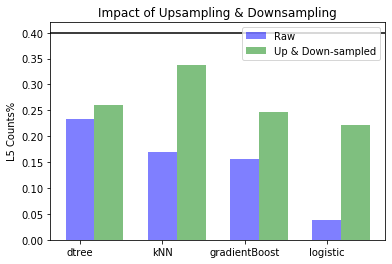

In [48]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

fig, ax = plt.subplots()
width = 0.35

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive = list(bias_d.values())
res = list(res_d.values())

y_pos = np.arange(len(objects))

p1 = ax.bar(y_pos, positive, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)

p2 = ax.bar(y_pos+width, res, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)

plt.axhline(y= round(test_neg/len(y_test), 1), color='black', linestyle='-')
ax.legend((p1[1], p2[1]), ('Raw', 'Up & Down-sampled'))

plt.xticks(y_pos, objects)
plt.ylabel('L5 Counts%')
plt.title('Impact of Upsampling & Downsampling')
 
plt.show()

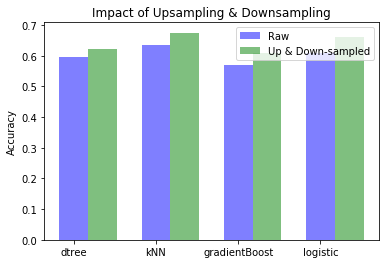

In [49]:
fig, ax = plt.subplots()

objects =  list(acc_bl.keys())
before =   list(acc_bl.values())
after =  list(acc_res.values())
y_pos = np.arange(len(objects))
p1 = ax.bar(y_pos, before, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width, after, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)
ax.legend((p1[1], p2[1]), ('Raw', 'Up & Down-sampled'))
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Impact of Upsampling & Downsampling')
plt.show()

### Upsampling and downsampling - Discussion

The solution we propose is to use both Upsampling and Downsampling on the training data. 
- The solution works pretty well, across multiple runs the bias is reduced. 
- The assessment is unstable in that different runs produce slightly different results. However, like upsampling, the results are much more staple than downsampling. 
- During most runs,the accuracy was slightly reduced for decision tree, while the accuracy increased for gradient Boosting, logistic regression and kNN.
### **This is a good strategy as it reduces the bias while also increasing the accuracy in general.**

# Compare strategies
I will not include Dwonsampling in this comparisson as the results were too inconsistant. I will compare the effects of Upsampling and upsampling & Downsampling.

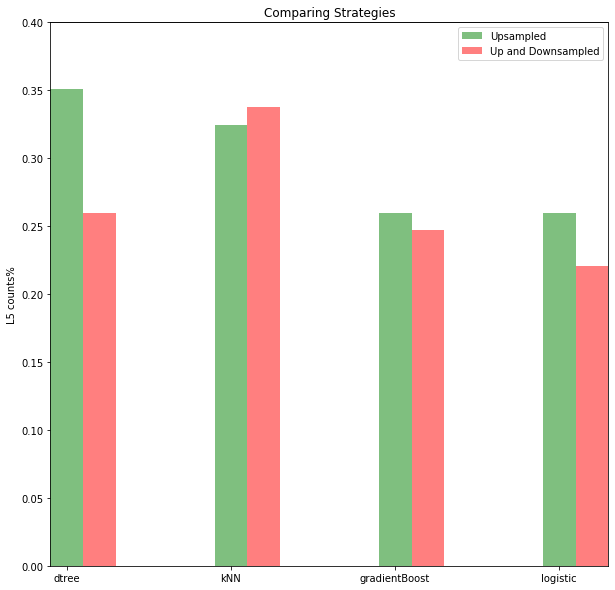

In [50]:
fig, ax = plt.subplots(figsize=(10,10))

objects =  list(acc_bl.keys())
up =  list(res2_d.values())
up_down = list(res_d.values())
y_pos = np.arange(len(objects))
width = 1.0/(3 + 2)

p1 = ax.bar(y_pos, up, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)
p2 = ax.bar(y_pos+width, up_down, width, align='center', 
            color=['red','red','red','red'],alpha=0.5)
plt.axhline(y= round(test_neg/len(y_test), 1), color='black', linestyle='-')

ax.legend((p1[1], p2[1]), ('Upsampled', 'Up and Downsampled'))
ax.autoscale(tight=True)
plt.xticks(y_pos, objects)
plt.ylabel('L5 counts%')
plt.title('Comparing Strategies')
plt.show()

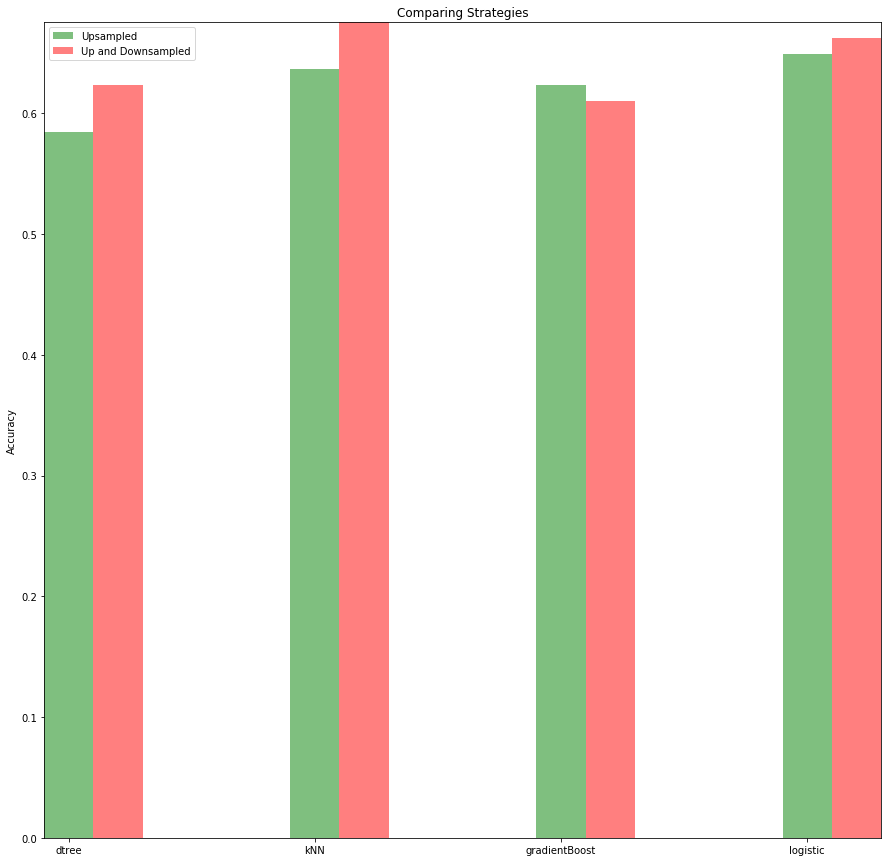

In [51]:
fig, ax = plt.subplots(figsize=(10,10))

objects =  list(acc_bl.keys())
up =  list(acc_res2.values())
up_down = list(acc_res.values())
y_pos = np.arange(len(objects))
width = 1.0/(3 + 2)

p1 = ax.bar(y_pos, up, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)
p2 = ax.bar(y_pos+width, up_down, width, align='center', 
            color=['red','red','red','red'],alpha=0.5)
ax.legend((p1[1], p2[1]), ('Upsampled', 'Up and Downsampled'))
ax.autoscale(tight=True)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Comparing Strategies')
plt.show()

### **In general, Upsampling seems to work best. As mentioned earlier the accuracy only decreased for decision trees using upsampling which shows that upsampling is a very good strategy. It significantly improved the bias while not effecting accuracy too much, in some cases even increasing accuracy.**

# Question 3
I decided to use the HotelRevHelpfulnessV2.csv file that was provided on brightspace.

In [65]:
hotel = pd.read_csv('HotelRevHelpfulnessV2.csv')
hotel.head()

,aveHelpfulnessRatioUser,stdevHelpfulnessRatioUser,pcReviewsExceedMinHelpfulnessSupport,numReviewsUser,numReviewsHotel,ratingUser,numberSubRatingsUser,subRatingMeanUser,subRatingStdevUser,aveRatingUser,...,completeness_2,completeness_3,numberTermsEntry,percentageAlphaCharsEntry,fractionUpperCaseCharsEntry,fractionYouVsIEntry,numberTermsSummaryQuote,percentageAlphaCharsSummaryQuote,fractionUpperCaseCharsSummaryQuote,reviewHelpfulness
0,1.000000,0.000000,0.666667,3,16,5,4,4.000000,0.000000,4.333333,...,0,1,182,0.788474,0.025703,0.500000,6,0.815789,0.096774,1
1,0.772487,0.377321,0.500000,12,233,5,0,0.000000,0.000000,4.333333,...,0,0,158,0.791888,0.012594,0.500000,1,1.000000,0.083333,1
2,0.715473,0.300437,0.833333,12,302,4,7,3.714286,0.755929,4.166667,...,0,3,59,0.799639,0.024831,0.333333,4,0.828571,0.034483,0
3,0.521250,0.481675,0.222222,36,6,1,4,1.000000,0.000000,3.527778,...,0,0,95,0.782212,0.029155,0.500000,2,0.800000,0.062500,0
4,0.603175,0.246926,1.000000,2,271,3,0,0.000000,0.000000,3.500000,...,0,0,43,0.805128,0.028662,0.000000,1,1.000000,0.142857,0


In [66]:
hotel['reviewHelpfulness'].value_counts() 

1    308
0    178
Name: reviewHelpfulness, dtype: int64

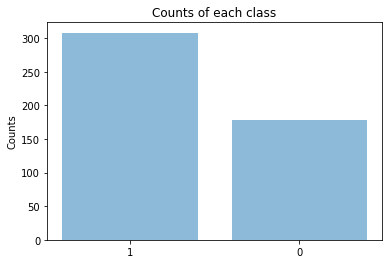

In [67]:
objects = ('1', '0')
y_pos = np.arange(len(objects))
performance = [len(hotel[hotel['reviewHelpfulness']==1]), len(hotel[hotel['reviewHelpfulness']==0])]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Counts')
plt.title('Counts of each class')

plt.show()

'reviewHelpfulness' is the class label. `1` is positive and `0` is negative.
You can see that this is a very unbalanced dataset.

In [68]:
y = hotel.pop('reviewHelpfulness').values
X = hotel.values
X.shape

(486, 23)

In [69]:
print("Original Dataset")
print("Minority class:",len(y) - y.sum())
print("Majority class:",y.sum())
print("Minority class: {:.2f}%".format((len(y)-y.sum())/len(y)*100))

Original Dataset
Minority class: 178
Majority class: 308
Minority class: 36.63%


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
bias_ds2 = {}
acc_bl = {}

print("Unhelpful in test set : %d" % (len(y_test) - y_test.sum()))

for m in model_d:
    y_pred = model_d[m].fit(X_train, y_train).predict(X_test)
    pred_count = (len(y_pred) - y_pred.sum())
    bias_ds2[m] = pred_count
    acc = accuracy_score(y_test, y_pred)
    acc_bl[m] = acc
  
    print("{:22}".format(type(model_d[m]).__name__))
    print(X_train.shape,X_test.shape)
    print('Accuracy:  %0.2f' % acc)
    print('F1:  %0.2f' % f1_score(y_test, y_pred)) 
    print("Pred. Unhelpful:", pred_count)
    print('*********************')

Unhelpful in test set : 46
DecisionTreeClassifier
(364, 23) (122, 23)
Accuracy:  0.61
F1:  0.70
Pred. Unhelpful: 36
*********************
KNeighborsClassifier  
(364, 23) (122, 23)
Accuracy:  0.62
F1:  0.72
Pred. Unhelpful: 36
*********************
GradientBoostingClassifier
(364, 23) (122, 23)
Accuracy:  0.71
F1:  0.80
Pred. Unhelpful: 27
*********************
LogisticRegression    
(364, 23) (122, 23)
Accuracy:  0.66
F1:  0.78
Pred. Unhelpful: 15
*********************


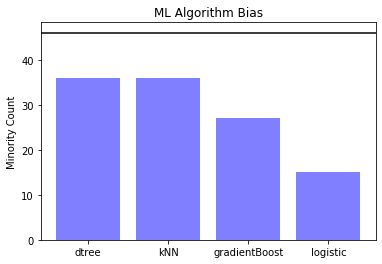

In [72]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive = list(bias_ds2.values())

y_pos = np.arange(len(objects))

plt.bar(y_pos, positive, align='center', color=[ 'blue', 'blue','blue','blue','blue','blue'],alpha=0.5)
len(y_test) - y_test.sum()
plt.axhline(y= len(y_test) - y_test.sum(), color='black', linestyle='-')
plt.xticks(y_pos, objects)
plt.ylabel('Minority Count')
plt.title('ML Algorithm Bias')
 
plt.show()

The test set contained 46 occurances of the minority .
- Assessment of bias is independent of accuracy, i.e. proportion of examples classified as the minority class compared with the actual proportion in the test set.
- Every model appears to be biased towards the majority class as each model predicts less than 46 minority occurances.
- Logistic regression showed the most bias, only predicting 15 minority class.
- Gradient boosting predicted only 26 minority class, which again is significantly lower than the target of 46.
- K-NN wasnt much better as it predicted 36 minority class.
- Decision tree showed the least biased predicting 39 minority class. Although this was the least biased it still is very biased towards the majority class.

During my analysis in **Question 2** I tested 3 strategies to rectify bias. The 3 strategies were:
- Downsampling
- Upsampling
- Upsampling and Downsampling<br/> 

Upsampling appeared to work best so I will just test that strategy for this dataset.

In [73]:
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [74]:
print("Original Training")
print("Majority class:",Counter(y_train)[1])
print("Minority class:", Counter(y_train)[0])
print("Upsampled Training")
print("Majority class:",Counter(y_train_res)[1])
print("Minority class:",Counter(y_train_res)[0])

Original Training
Majority class: 232
Minority class: 132
Upsampled Training
Majority class: 232
Minority class: 232


In [75]:
res_ds2 = {}
acc_res = {}

print("Unhelpful in test set : %d" % (len(y_test) - y_test.sum()))

for m in model_d:
    y_pred = model_d[m].fit(X_train_res, y_train_res).predict(X_test)
    pred_count = (len(y_pred) - y_pred.sum())
    res_ds2[m] = pred_count
    acc = accuracy_score(y_test, y_pred)
    acc_res[m] = acc
  
    print("{:22}".format(type(model_d[m]).__name__))
    print(X_train.shape,X_test.shape)
    print('Accuracy:  %0.2f' % acc)
    print('F1:  %0.2f' % f1_score(y_test, y_pred))
    print("Pred. Unhelpful: {:d}", pred_count)
    print('*********************')

Unhelpful in test set : 46
DecisionTreeClassifier
(364, 23) (122, 23)
Accuracy:  0.70
F1:  0.75
Pred. Unhelpful: {:d} 47
*********************
KNeighborsClassifier  
(364, 23) (122, 23)
Accuracy:  0.62
F1:  0.68
Pred. Unhelpful: {:d} 52
*********************
GradientBoostingClassifier
(364, 23) (122, 23)
Accuracy:  0.75
F1:  0.80
Pred. Unhelpful: {:d} 41
*********************
LogisticRegression    
(364, 23) (122, 23)
Accuracy:  0.61
F1:  0.67
Pred. Unhelpful: {:d} 55
*********************


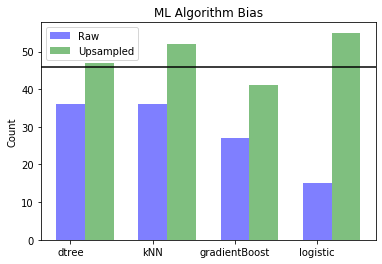

In [76]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

fig, ax = plt.subplots()
width = 0.35

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive = list(bias_ds2.values())
res = list(res_ds2.values())

y_pos = np.arange(len(objects))

p1 = ax.bar(y_pos, positive, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)

p2 = ax.bar(y_pos+width, res, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)

plt.axhline(y= len(y_test) - y_test.sum(), color='black', linestyle='-')

ax.legend((p1[1], p2[1]), ('Raw', 'Upsampled'))

plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('ML Algorithm Bias')
 
plt.show()

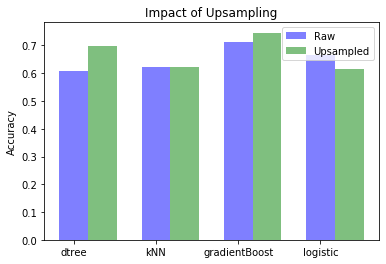

In [77]:
fig, ax = plt.subplots()

objects =  list(acc_bl.keys())
before =   list(acc_bl.values())
after =  list(acc_res.values())
y_pos = np.arange(len(objects))
p1 = ax.bar(y_pos, before, width, align='center', 
            color=['blue', 'blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width, after, width, align='center', 
            color=['g','g','g','g'],alpha=0.5)
ax.legend((p1[1], p2[1]), ('Raw', 'Upsampled'))
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Impact of Upsampling')
plt.show()

### Second Dataset Discussion  
The results on the second dataset are again quite positive. 
- There is good improvement on bias.
- There was an increase in accuracy for both decision tree and gradient boosting.
- kNN accuracy remained the same.
- Logistic regression is the only model that seen a decrease in accuracy. 
- It seems that **decision tree** offers the best balance between bias and accuracy.
  - Decision tree predicted 47 occurances of the minority class whish is just 1 more than the actual amount of occurance(46), showing no bias.
- It seems that **gradient boosting** offers the second best balance between bias and accuracy.
  - Gradient boosting predicted 41 occurances of the minority class whish is just 5 less than the actual amount of occurance(46), showing very little bias.
### **Once again, upsampling proves to be a good strategy to rectify bias.**